<a href="https://colab.research.google.com/github/ThalesF01/Projeto-Curso-IA/blob/main/Projeto_curso_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===================== Célula 1: Instalações e imports =====================
!pip -q install catboost imblearn shap lightgbm xgboost scikit-optimize

import os
import json
import joblib
import warnings
from time import time

import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import shap
import seaborn as sns

warnings.filterwarnings("ignore")
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.2 MB/s eta 0:00:00


In [2]:
# ===================== Célula 2: Carregar dataset =====================
train_path = "train.csv"
val_path = "validation.csv"

dataset = pd.read_csv(train_path, keep_default_na=False)
y = dataset['income'].map({'<=50K':0, '>50K':1})
X = dataset.drop(columns=['income']).copy()

df_val = pd.read_csv(val_path, keep_default_na=False)
X_val_raw = df_val.drop(columns=['income']).copy()
y_val = df_val['income'].map({'<=50K':0, '>50K':1})

In [3]:
# ===================== Célula 3: Preprocessing functions (igual para treino/val) =====================
def replace_unknowns(df, cat_cols):
    df[cat_cols] = df[cat_cols].replace("?", "Unknown")
    return df

def group_rares(df, col_list, threshold=0.01, reference_series=None):
    # reference_series: series from training data for defining rare categories
    for col in col_list:
        if col in df.columns:
            if reference_series is None:
                freq = df[col].value_counts(normalize=True)
                raras = freq[freq < threshold].index
                df[col] = df[col].apply(lambda v: 'Others' if v in raras else v)
            else:
                # any unseen category becomes 'Others' if not in seen set
                seen = set(reference_series[col].unique())
                df[col] = df[col].apply(lambda v: v if v in seen else 'Others')
    return df

def add_engineered_features(df):
    # log1p capital gain/loss
    if 'capital-gain' in df.columns:
        df['capital_gain_log1p'] = np.log1p(pd.to_numeric(df['capital-gain'], errors='coerce').fillna(0))
        df['has_capital_gain'] = (pd.to_numeric(df['capital-gain'], errors='coerce').fillna(0) > 0).astype(int)
    if 'capital-loss' in df.columns:
        df['capital_loss_log1p'] = np.log1p(pd.to_numeric(df['capital-loss'], errors='coerce').fillna(0))
    # bins
    if 'age' in df.columns:
        df['age_bin'] = pd.cut(df['age'], bins=[0,25,35,45,55,65,120], labels=False, include_lowest=True)
    if 'hours-per-week' in df.columns:
        df['hours_bin'] = pd.cut(df['hours-per-week'], bins=[0,20,30,40,50,60,99], labels=False, include_lowest=True)
    # interaction
    if {'hours-per-week','educational-num'}.issubset(df.columns):
        df['hrs_x_edu'] = df['hours-per-week'] * df['educational-num']
    return df

def clip_by_quantile(s, low=0.01, high=0.99):
    lo, hi = s.quantile([low, high])
    return s.clip(lo, hi)

def clip_cols_like_train(df, reference_df, cols=['hours-per-week','age']):
    for col in cols:
        if col in df.columns and col in reference_df.columns:
            lo, hi = reference_df[col].quantile([0.01, 0.99])
            df[col] = df[col].astype(float).clip(lo, hi)
    return df

# Apply preprocessing to train
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X = replace_unknowns(X, cat_cols)
X = group_rares(X, ['race','native-country','workclass'], reference_series=None)
X = add_engineered_features(X)
for col in ['hours-per-week','age']:
    if col in X.columns:
        X[col] = clip_by_quantile(X[col].astype(float))
# recompute cat/num sets after feature engineering
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Apply same preprocessing to validation (use train as reference for grouping)
Xv = X_val_raw.copy()
Xv = replace_unknowns(Xv, cat_cols)
Xv = group_rares(Xv, ['race','native-country','workclass'], reference_series=X)
Xv = add_engineered_features(Xv)
Xv = clip_cols_like_train(Xv, X, cols=['hours-per-week','age'])

In [4]:
# ===================== Célula 4: Encoders e scaler (treinar em treino) =====================
# OrdinalEncoder com handling para unknowns (usa -1 para unknown)
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

if len(cat_cols) > 0:
    ord_enc.fit(X[cat_cols])
    X_enc_cat = ord_enc.transform(X[cat_cols])
    Xv_enc_cat = ord_enc.transform(Xv[cat_cols])
else:
    X_enc_cat = np.zeros((len(X),0))
    Xv_enc_cat = np.zeros((len(Xv),0))

scaler = StandardScaler()
X_num = X[num_cols].fillna(0).values if len(num_cols) else np.zeros((len(X),0))
Xv_num = Xv[num_cols].fillna(0).values if len(num_cols) else np.zeros((len(Xv),0))

scaler.fit(X_num)
X_num_s = scaler.transform(X_num)
Xv_num_s = scaler.transform(Xv_num)

# Rebuild encoded DataFrames
X_enc = pd.DataFrame(np.hstack([X_num_s, X_enc_cat]),
                     columns = list(num_cols) + list(cat_cols),
                     index = X.index)
X_val_enc = pd.DataFrame(np.hstack([Xv_num_s, Xv_enc_cat]),
                         columns = list(num_cols) + list(cat_cols),
                         index = Xv.index)

# Save encoders/scaler
os.makedirs("artifacts", exist_ok=True)
joblib.dump(ord_enc, "artifacts/ordinal_encoder.joblib")
joblib.dump(scaler, "artifacts/scaler.joblib")

# For CatBoost we need categorical feature indices (positions in encoded DF)
cat_feature_indices = [X_enc.columns.get_loc(c) for c in cat_cols] if len(cat_cols) else []

print("Features (num):", len(num_cols), " Features (cat):", len(cat_cols))

Features (num): 12  Features (cat): 8


In [10]:
# ===================== Célula 5: Hyperparameter tuning (RandomizedSearchCV + SMOTEENN) =====================
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from imblearn.combine import SMOTEENN
from sklearn.utils.class_weight import compute_class_weight
import os, json, joblib, inspect
from time import time
from scipy.stats import randint as sp_randint, uniform as sp_uniform

def _fit_with_possible_early_stopping(estimator, X_tr_res, y_tr_res, X_es, y_es, es_rounds=30):
    """
    Tenta aplicar early stopping de forma robusta:
      1) passar early_stopping_rounds diretamente se o signature do fit aceitar
      2) usar callbacks=[lgb.early_stopping(...)] se o método aceitar callbacks
      3) fallback: reduzir n_estimators e treinar sem early stopping
    Retorna o estimator treinado.
    """
    try:
        fit_sig = inspect.signature(estimator.fit)
    except Exception:
        fit_sig = None

    # 1) early_stopping_rounds direto
    try:
        if fit_sig and 'early_stopping_rounds' in fit_sig.parameters and 'eval_set' in fit_sig.parameters:
            estimator.fit(X_tr_res, y_tr_res, eval_set=[(X_es, y_es)], early_stopping_rounds=es_rounds, verbose=False)
            return estimator
    except Exception:
        pass

    # 2) callbacks (LightGBM modern)
    try:
        if fit_sig and 'callbacks' in fit_sig.parameters and 'eval_set' in fit_sig.parameters:
            try:
                estimator.fit(X_tr_res, y_tr_res, eval_set=[(X_es, y_es)], callbacks=[lgb.early_stopping(es_rounds)], verbose=False)
                return estimator
            except Exception:
                pass
    except Exception:
        pass

    # 3) fallback: reduzir n_estimators (se existir) para economizar tempo e treinar sem early stopping
    try:
        params = estimator.get_params()
        if 'n_estimators' in params:
            new_n = max(50, int(params['n_estimators'] * 0.5))
            estimator.set_params(n_estimators=new_n)
    except Exception:
        pass

    estimator.fit(X_tr_res, y_tr_res, verbose=False)
    return estimator


def randomized_search_model(model_name, base_estimator, param_dist, X_for_search, y_for_search,
                            json_file, n_iter=12, cv=2, random_state=42, es_rounds=30):
    """
    - Pipeline [SMOTEENN -> clf]
    - RandomizedSearchCV para achar melhores params (sem early stopping)
    - Refit final com early stopping quando aplicável (XGB/LGB) de forma robusta
    """
    pipeline = ImbPipeline([('res', SMOTEENN(random_state=random_state)),
                            ('clf', base_estimator)])

    if os.path.exists(json_file):
        print(f"[{model_name}] Carregando melhores parâmetros de {json_file}...")
        with open(json_file, 'r') as f:
            best_params = json.load(f)
        clf_best = {k.replace('clf__',''): v for k,v in best_params.items()}
        estimator = base_estimator.set_params(**clf_best)
        final_pipe = ImbPipeline([('res', SMOTEENN(random_state=random_state)),
                                  ('clf', estimator)])
        print(f"[{model_name}] Refit final com melhores params (arquivo encontrado).")
        final_pipe.fit(X_for_search, y_for_search)
        return final_pipe

    print(f"[{model_name}] Rodando RandomizedSearchCV (n_iter={n_iter}, cv={cv})...")
    cv_obj = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    rnd = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=n_iter,
                             scoring='f1', cv=cv_obj, n_jobs=-1, verbose=2, random_state=random_state)
    rnd.fit(X_for_search, y_for_search)
    print(f"[{model_name}] Best score: {rnd.best_score_:.4f}")

    best_params = {k: v for k,v in rnd.best_params_.items()}
    with open(json_file, 'w') as f:
        json.dump(best_params, f, indent=4)
    print(f"[{model_name}] Parâmetros salvos em {json_file}. Refit final em todo o conjunto com early_stopping quando aplicável.")

    # Refit final
    clf_params = {k.replace('clf__',''):v for k,v in best_params.items()}
    estimator_final = base_estimator.set_params(**clf_params)

    # Se for XGB/LGB, usar holdout para early stopping
    if isinstance(estimator_final, XGBClassifier) or isinstance(estimator_final, lgb.LGBMClassifier):
        X_tr, X_es, y_tr, y_es = train_test_split(X_for_search, y_for_search, test_size=0.1,
                                                  stratify=y_for_search, random_state=random_state)
        # resample com SMOTEENN (apenas no treino)
        X_tr_res, y_tr_res = SMOTEENN(random_state=random_state).fit_resample(X_tr, y_tr)

        if isinstance(estimator_final, XGBClassifier):
            # XGB suporta early_stopping_rounds diretamente
            estimator_final.fit(X_tr_res, y_tr_res, eval_set=[(X_es, y_es)], early_stopping_rounds=es_rounds, verbose=False)
        else:
            # LightGBM: usar função robusta que tenta callbacks ou fallback
            estimator_final = _fit_with_possible_early_stopping(estimator_final, X_tr_res, y_tr_res, X_es, y_es, es_rounds=es_rounds)

    # Pipeline final (com SMOTEENN) e fit final
    final_pipe = ImbPipeline([('res', SMOTEENN(random_state=random_state)),
                              ('clf', estimator_final)])
    final_pipe.fit(X_for_search, y_for_search)
    return final_pipe


# ===================== Param distributions (corrigidos e reduzidos) =====================
scale_pos_weight = max(1.0, (y==0).sum() / max(1,(y==1).sum()))
xgb_param_dist = {
    'clf__n_estimators': sp_randint(200, 350),
    'clf__max_depth': sp_randint(3, 6),
    'clf__learning_rate': sp_uniform(0.05, 0.06),
    'clf__subsample': sp_uniform(0.8, 0.2),
    'clf__colsample_bytree': sp_uniform(0.8, 0.2),
    'clf__min_child_weight': sp_randint(1, 4),
    'clf__reg_alpha': sp_uniform(0.0, 0.3),
    'clf__reg_lambda': sp_uniform(0.3, 0.7),
    'clf__scale_pos_weight': [scale_pos_weight]
}

lgb_param_dist = {
    'clf__n_estimators': sp_randint(200, 350),
    'clf__num_leaves': sp_randint(24, 48),
    'clf__max_depth': sp_randint(3, 10),
    'clf__learning_rate': sp_uniform(0.05, 0.06),
    'clf__min_child_samples': sp_randint(12,30),
    'clf__reg_alpha': sp_uniform(0.0, 0.3),
    'clf__reg_lambda': sp_uniform(0.2, 0.6),
    'clf__subsample': sp_uniform(0.8, 0.2),
    'clf__colsample_bytree': sp_uniform(0.8, 0.2),
}

cat_param_dist = {
    'clf__iterations': sp_randint(300, 500),
    'clf__depth': sp_randint(4,6),
    'clf__learning_rate': sp_uniform(0.05, 0.06),
    'clf__l2_leaf_reg': sp_uniform(1.0, 3.0)
}

# ===================== Instantiate base estimators =====================
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, tree_method='hist', n_jobs=1)
lgb_base = lgb.LGBMClassifier(random_state=42, n_jobs=1)
cat_base = CatBoostClassifier(random_seed=42, verbose=0, thread_count=1)

# ===================== Run Randomized Search (menos combinações) =====================
t0 = time()
best_xgb_pipe = randomized_search_model("XGBoost", xgb_base, xgb_param_dist, X_enc, y, "artifacts/xgb_params_random.json", n_iter=12, cv=2)
print("XGB search time (s):", time()-t0)

t0 = time()
best_lgb_pipe = randomized_search_model("LightGBM", lgb_base, lgb_param_dist, X_enc, y, "artifacts/lgb_params_random.json", n_iter=12, cv=2)
print("LGB search time (s):", time()-t0)

t0 = time()
cw = compute_class_weight(class_weight='balanced', classes=np.array([0,1]), y=y)
class_weights_cb = {0: float(cw[0]), 1: float(cw[1])}
cat_base = CatBoostClassifier(random_seed=42, verbose=0, thread_count=1, class_weights=class_weights_cb)
best_cat_pipe = randomized_search_model("CatBoost", cat_base, cat_param_dist, X_enc, y, "artifacts/cat_params_random.json", n_iter=10, cv=2)
print("Cat search time (s):", time()-t0)

# ===================== Salvando pipelines e classificadores =====================
best_xgb = best_xgb_pipe.named_steps['clf']
best_lgb = best_lgb_pipe.named_steps['clf']
best_cat = best_cat_pipe.named_steps['clf']

joblib.dump(best_xgb_pipe, "artifacts/best_xgb_pipeline.joblib")
joblib.dump(best_lgb_pipe, "artifacts/best_lgb_pipeline.joblib")
joblib.dump(best_cat_pipe, "artifacts/best_cat_pipeline.joblib")


[XGBoost] Carregando melhores parâmetros de artifacts/xgb_params_random.json...
[XGBoost] Refit final com melhores params (arquivo encontrado).
XGB search time (s): 27.473886489868164
[LightGBM] Carregando melhores parâmetros de artifacts/lgb_params_random.json...
[LightGBM] Refit final com melhores params (arquivo encontrado).
[LightGBM] [Info] Number of positive: 20651, number of negative: 17886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4848
[LightGBM] [Info] Number of data points in the train set: 38537, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535875 -> initscore=0.143745
[LightGBM] [Info] Start training from score 0.143745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

['artifacts/best_cat_pipeline.joblib']

In [13]:
# ===================== Célula 6: OOF predictions (cross_val_predict) para meta (SMOTEENN dentro de pipeline) =====================
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict

# manter StratifiedKFold (pode reduzir n_splits se quiser acelerar)
skf_oof = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Clone os estimadores já treinados e force single-thread internamente (evita oversubscription)
xgb_clone = clone(best_xgb)
try:
    xgb_clone.set_params(n_jobs=1)  # força 1 thread por estimador
except Exception:
    pass

lgb_clone = clone(best_lgb)
try:
    lgb_clone.set_params(n_jobs=1)
except Exception:
    pass

cat_clone = clone(best_cat)
try:
    cat_clone.set_params(thread_count=1, verbose=0)
except Exception:
    pass

# Pipelines com SMOTEENN (OOF correto)
pipe_xgb_oof = ImbPipeline([('res', SMOTEENN(random_state=42)),
                            ('clf', xgb_clone)])
pipe_lgb_oof = ImbPipeline([('res', SMOTEENN(random_state=42)),
                            ('clf', lgb_clone)])
pipe_cat_oof = ImbPipeline([('res', SMOTEENN(random_state=42)),
                            ('clf', cat_clone)])

# Generate OOF probabilities (pode demorar)
print("Gerando OOF probs (isto pode demorar)...")
# Para XGB/LGB podemos paralelizar folds (n_jobs=-1) porque estimadores usam 1 thread cada
oof_xgb = cross_val_predict(pipe_xgb_oof, X_enc, y, cv=skf_oof, method='predict_proba', n_jobs=-1)[:,1]
oof_lgb = cross_val_predict(pipe_lgb_oof, X_enc, y, cv=skf_oof, method='predict_proba', n_jobs=-1)[:,1]

# CatBoost + SMOTEENN costuma ser sensível a paralelismo; use n_jobs=1 para segurança
oof_cat = cross_val_predict(pipe_cat_oof, X_enc, y, cv=skf_oof, method='predict_proba', n_jobs=1)[:,1]

# Save OOF arrays for debugging
np.save("artifacts/oof_xgb.npy", oof_xgb)
np.save("artifacts/oof_lgb.npy", oof_lgb)
np.save("artifacts/oof_cat.npy", oof_cat)

# Train meta-model on OOFs
meta_X = np.vstack([oof_xgb, oof_lgb, oof_cat]).T
meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(meta_X, y)
joblib.dump(meta_clf, "artifacts/meta_clf.joblib")

print("OOF gerados e meta-modelo treinado.")


Gerando OOF probs (isto pode demorar)...
OOF gerados e meta-modelo treinado.


In [18]:
# ===================== Célula 7: Calibrated final models =====================
from sklearn.calibration import CalibratedClassifierCV
import joblib

print("Calibrating final models (para probabilidades mais consistentes)...")

# ----- XGB -----
xgb_params = best_xgb.get_params().copy()
for k in ['use_label_encoder', 'eval_metric', 'tree_method']:
    xgb_params.pop(k, None)

calib_xgb = CalibratedClassifierCV(
    estimator=XGBClassifier(**xgb_params, use_label_encoder=False, eval_metric='logloss', tree_method='hist'),
    cv=3,
    method='sigmoid'
)

# ----- LGB -----
calib_lgb = CalibratedClassifierCV(
    estimator=lgb.LGBMClassifier(**best_lgb.get_params()),
    cv=3,
    method='sigmoid'
)

# ----- CatBoost -----
cat_params = best_cat.get_params().copy()
for k in ['verbose', 'thread_count', 'random_seed']:
    cat_params.pop(k, None)

calib_cat = CalibratedClassifierCV(
    estimator=CatBoostClassifier(**cat_params, verbose=0),
    cv=3,
    method='sigmoid'
)

# ----- Fit (pode demorar) -----
calib_xgb.fit(X_enc, y)
calib_lgb.fit(X_enc, y)
calib_cat.fit(X_enc, y)

# ----- Salvar modelos -----
joblib.dump(calib_xgb, "artifacts/calib_xgb.joblib")
joblib.dump(calib_lgb, "artifacts/calib_lgb.joblib")
joblib.dump(calib_cat, "artifacts/calib_cat.joblib")


Calibrating final models (para probabilidades mais consistentes)...
[LightGBM] [Info] Number of positive: 5511, number of negative: 17281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 22792, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241795 -> initscore=-1.142862
[LightGBM] [Info] Start training from score -1.142862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


['artifacts/calib_cat.joblib']

In [19]:
# ===================== Célula 8: Avaliação individual no conjunto de validação =====================
def threshold_tuning_from_probs(probs, ytrue):
    prec, rec, thr = precision_recall_curve(ytrue, probs)
    f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = f1s.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return best_thr, f1s[best_idx]

probs_xgb_val = calib_xgb.predict_proba(X_val_enc)[:,1]
probs_lgb_val = calib_lgb.predict_proba(X_val_enc)[:,1]
probs_cat_val = calib_cat.predict_proba(X_val_enc)[:,1]

thr_xgb, f1_xgb = threshold_tuning_from_probs(probs_xgb_val, y_val)
thr_lgb, f1_lgb = threshold_tuning_from_probs(probs_lgb_val, y_val)
thr_cat, f1_cat = threshold_tuning_from_probs(probs_cat_val, y_val)

y_pred_xgb = (probs_xgb_val >= thr_xgb).astype(int)
y_pred_lgb = (probs_lgb_val >= thr_lgb).astype(int)
y_pred_cat = (probs_cat_val >= thr_cat).astype(int)

print("=== XGBoost ===")
print(f"Melhor threshold: {thr_xgb:.4f}, F1: {f1_xgb:.4f}")
print(classification_report(y_val, y_pred_xgb))

print("=== LightGBM ===")
print(f"Melhor threshold: {thr_lgb:.4f}, F1: {f1_lgb:.4f}")
print(classification_report(y_val, y_pred_lgb))

print("=== CatBoost ===")
print(f"Melhor threshold: {thr_cat:.4f}, F1: {f1_cat:.4f}")
print(classification_report(y_val, y_pred_cat))

=== XGBoost ===
Melhor threshold: 0.3629, F1: 0.7218
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      5642
           1       0.66      0.80      0.72      1684

    accuracy                           0.86      7326
   macro avg       0.80      0.84      0.81      7326
weighted avg       0.87      0.86      0.86      7326

=== LightGBM ===
Melhor threshold: 0.2901, F1: 0.7231
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      5642
           1       0.67      0.79      0.72      1684

    accuracy                           0.86      7326
   macro avg       0.80      0.84      0.82      7326
weighted avg       0.87      0.86      0.86      7326

=== CatBoost ===
Melhor threshold: 0.4548, F1: 0.7307
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      5642
           1       0.70      0.76      0.73      1684

    accuracy         

Melhores pesos (xgb, lgb, cat): 0.00, 0.20, 0.80  -> F1 validação: 0.7327, thr: 0.4166
=== Ensemble (pesos otimizados) ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      5642
           1       0.69      0.77      0.73      1684

    accuracy                           0.87      7326
   macro avg       0.81      0.84      0.82      7326
weighted avg       0.88      0.87      0.87      7326



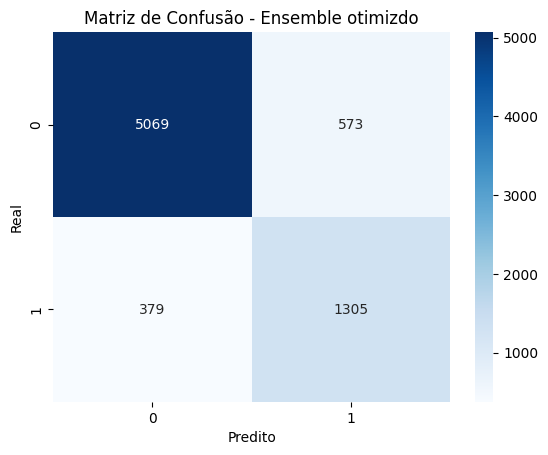

In [20]:
# ===================== Célula 9: Ensemble - otimização de pesos via busca simples =====================
# Definimos uma grade simples para pesos (coarse). Você pode refinar depois.
best_weights = None
best_f1 = -1
grid = np.linspace(0,1,11)

for wx in grid:
    for wl in grid:
        if wx + wl > 1:
            continue
        wc = 1 - wx - wl
        probs = wx*probs_xgb_val + wl*probs_lgb_val + wc*probs_cat_val
        # otimizar threshold interno (usar F1 com threshold tunado por PR curve => testamos threshold por PR)
        thr, _ = threshold_tuning_from_probs(probs, y_val)
        y_pred = (probs >= thr).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_weights = (wx, wl, wc)
            best_thr_for_best = thr

wx, wl, wc = best_weights
print(f"Melhores pesos (xgb, lgb, cat): {wx:.2f}, {wl:.2f}, {wc:.2f}  -> F1 validação: {best_f1:.4f}, thr: {best_thr_for_best:.4f}")

probs_ensemble = wx*probs_xgb_val + wl*probs_lgb_val + wc*probs_cat_val
y_pred_ens = (probs_ensemble >= best_thr_for_best).astype(int)
print("=== Ensemble (pesos otimizados) ===")
print(classification_report(y_val, y_pred_ens))

cm = confusion_matrix(y_val, y_pred_ens)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito"); plt.ylabel("Real"); plt.title("Matriz de Confusão - Ensemble otimizdo")
plt.show()

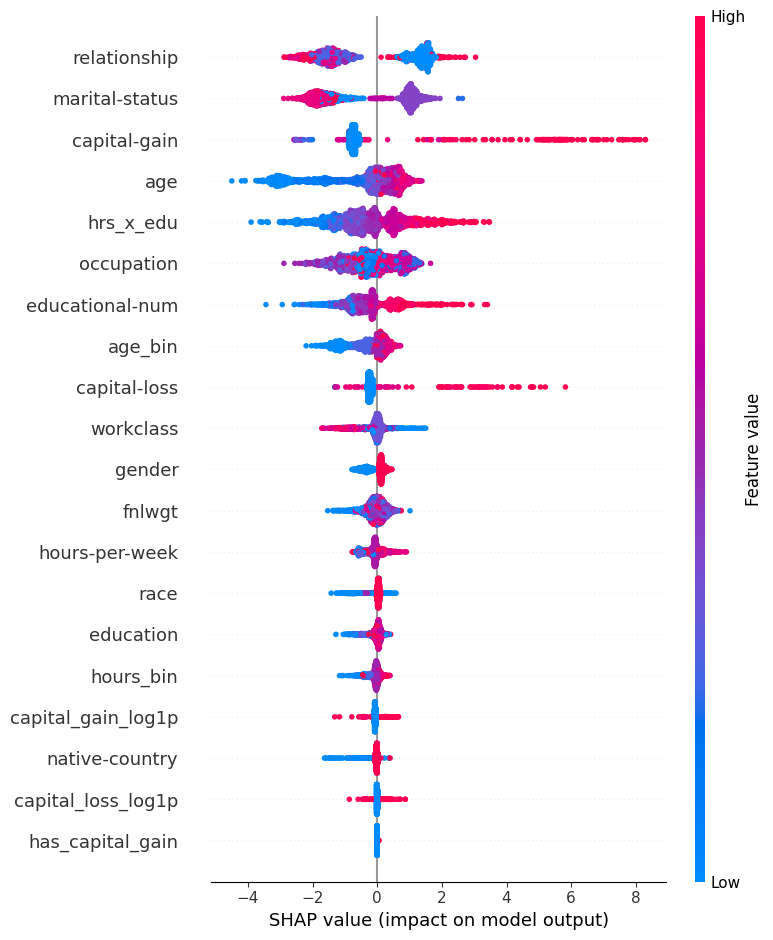

In [21]:
# ===================== Célula 10: SHAP (explicações) =====================
# Use uma amostra para velocidade
sample_idx = np.random.choice(len(X_val_enc), size=min(2000, len(X_val_enc)), replace=False)
explainer_lgb = shap.TreeExplainer(best_lgb)
shap_vals_lgb = explainer_lgb.shap_values(X_val_enc.iloc[sample_idx])
shap.summary_plot(shap_vals_lgb, X_val_enc.iloc[sample_idx], show=True)

In [ ]:
# ===================== Célula 11: (Opcional) Seleção de features com SHAP e refit rápido =====================
REFIT_WITH_SHAP_SELECTION = False
if REFIT_WITH_SHAP_SELECTION:
    mean_abs = np.mean(np.abs(shap_vals_lgb), axis=0)
    feat_importance = pd.Series(mean_abs, index=X_val_enc.columns).sort_values(ascending=False)
    TOP_K = 25
    keep_cols = list(feat_importance.head(TOP_K).index)
    print("Top features:", keep_cols)
    # refit classifiers quickly on reduced feature set (usando pipelines previamente montados)
    X_enc_shap = X_enc[keep_cols]
    X_val_enc_shap = X_val_enc[keep_cols]
    # Refit simple clones
    xgb_r = XGBClassifier(**best_xgb.get_params(), use_label_encoder=False, eval_metric='logloss', tree_method='hist')
    lgb_r = lgb.LGBMClassifier(**best_lgb.get_params())
    cat_r = CatBoostClassifier(**best_cat.get_params(), verbose=0)
    xgb_r.fit(X_enc_shap, y)
    lgb_r.fit(X_enc_shap, y)
    cat_r.fit(X_enc_shap, y)
    probs_xgb_r = xgb_r.predict_proba(X_val_enc_shap)[:,1]
    probs_lgb_r = lgb_r.predict_proba(X_val_enc_shap)[:,1]
    probs_cat_r = cat_r.predict_proba(X_val_enc_shap)[:,1]
    probs_ens_r = wx*probs_xgb_r + wl*probs_lgb_r + wc*probs_cat_r
    thr_r, _ = threshold_tuning_from_probs(probs_ens_r, y_val)
    print("Refit with SHAP top K ensemble report:")
    print(classification_report(y_val, (probs_ens_r >= thr_r).astype(int)))

In [ ]:
# ===================== Célula 12: Salvar artefatos finais =====================
joblib.dump(ord_enc, "artifacts/ordinal_encoder.joblib")
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(meta_clf, "artifacts/meta_clf.joblib")
joblib.dump({"wx":wx, "wl":wl, "wc":wc, "thr":best_thr_for_best}, "artifacts/ensemble_weights_and_thr.joblib")
# Save calibrated models
joblib.dump(calib_xgb, "artifacts/calib_xgb.joblib")
joblib.dump(calib_lgb, "artifacts/calib_lgb.joblib")
joblib.dump(calib_cat, "artifacts/calib_cat.joblib")

print("Todos artefatos salvos em ./artifacts. Fim.")